# Example usage with Qiskit
This notebook demonstrates several examples of generating Quantum Convolutional Neural Networks (QCNNs) using the package. Default circuits/ansatzes for convolution and pooling operations are shown, such as the CRZ gate for convolutions and CNOT for pooling, to facilitate an easy visual representation of the package's functionality. The section [custom unitaries](#sec_customunitary) illustrates how to specify custom unitaries for convolutions, pooling, or other primitives.

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [1]:
# Load libraries
import numpy as np

In [2]:
# Core library functionality
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    plot_graph
)

In [3]:
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister

from dynamic_qcnn.qiskit import convert_graph_to_circuit_qiskit

### Basic example
We create one of the architectures discussed in [Lourens et al.](https://arxiv.org/pdf/2210.15073.pdf). This architecture is semantically described as repeating a convolution of stride 1 and pooling from bottom to top on 8 qubits until one remain.

<img src="../img/hierarchical_motifs.drawio.svg" alt="hierarchical motifs" width="900"/>

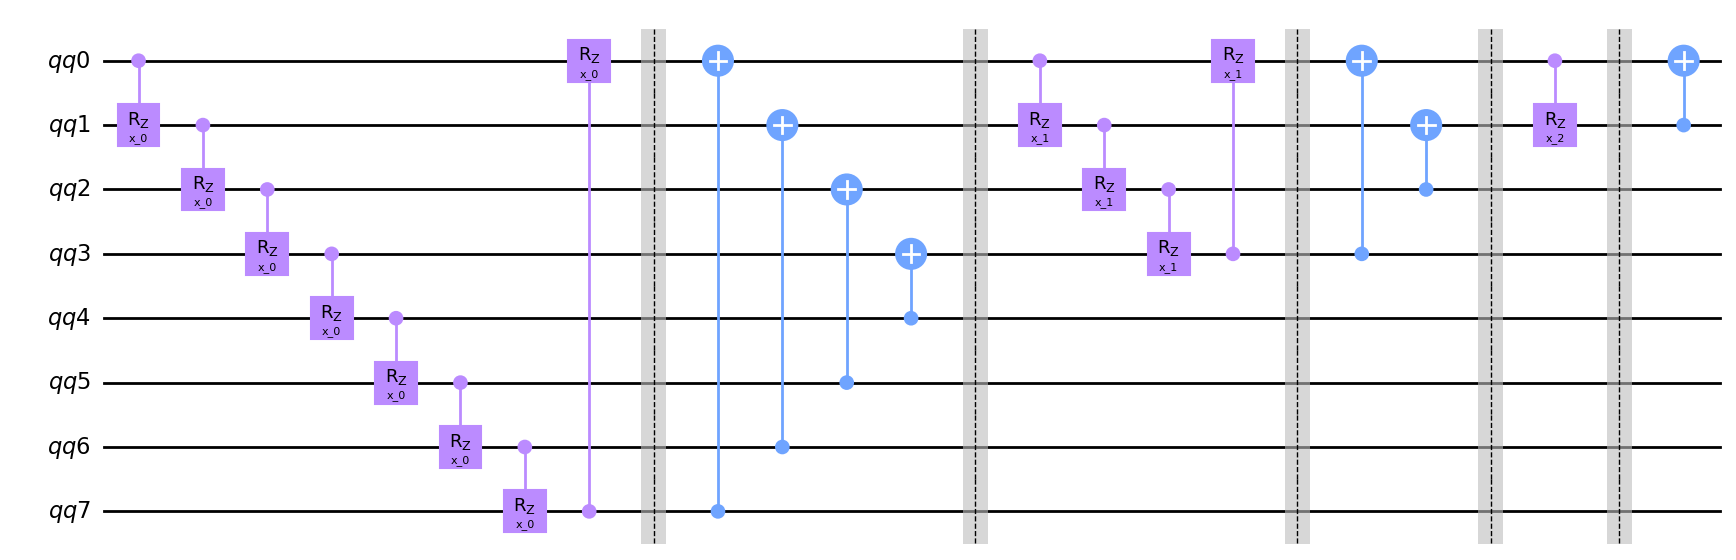

In [4]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3

circuit, symbols = convert_graph_to_circuit_qiskit(m)
circuit.draw("mpl")

### Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer such as convolution or pooling and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - qcnn = (Convolution, Pooling, Convolution, Pooling, Convolution, Convolution, Convolution, Pooling, Convolution, Pooling)

**Hierarchical view**
 - m2_1 = (Convolution, Pooling)
 - m2_2 = (Convolution, Convolution)
 - m3_1 = (m2_1, m2_1)
 - qcnn = (m3_1, m2_2, m3_1)

#### Convolution primitive

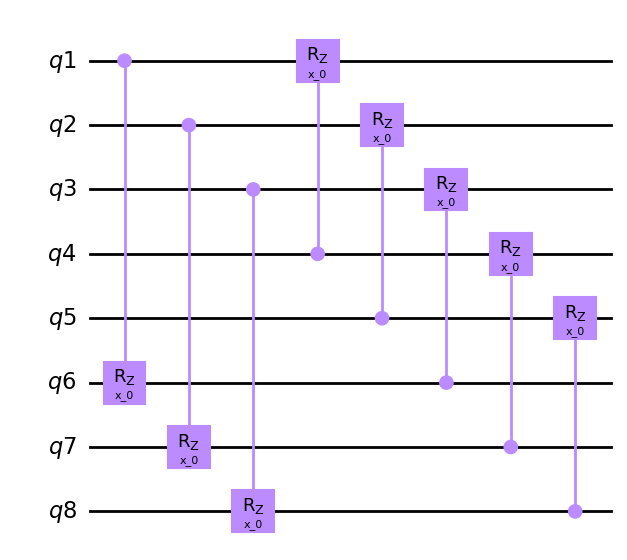

In [50]:
# Convolution of stride 3, try out other stride values
convolution = Qconv(stride=5) 
conv_on_8_qubits = Qfree(8) + convolution

circuit, symbols = convert_graph_to_circuit_qiskit(conv_on_8_qubits)
circuit.draw("mpl")

#### Pooling primitive

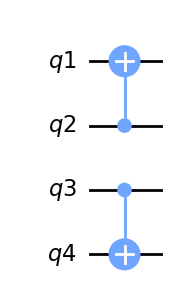

In [6]:
# Pooling from inside out, other values for filter: right, left, inside, outside, even, odd or a bitstring like 0100
pooling = Qpool(filter="inside")
pool_on_4_qubits = Qfree(4) + pooling

circuit, symbols = convert_graph_to_circuit_qiskit(pool_on_4_qubits)
circuit.draw("mpl")

#### Dense primitive

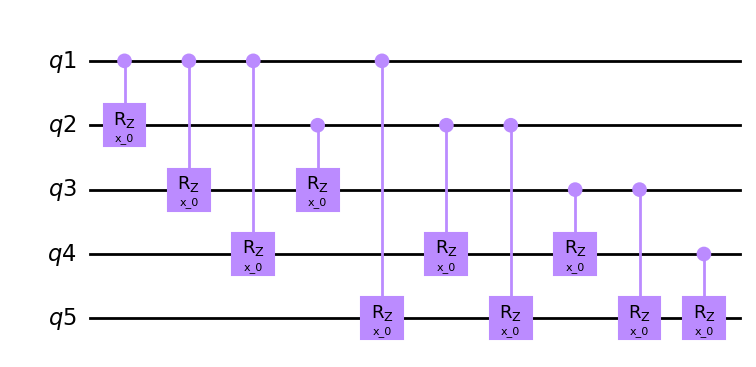

In [52]:
# Dense primitive, does all pairwise combinations between available qubits, for all permutations set permutations=True
dense = Qdense(permutations=False)
dense_on_5_qubits = Qfree(5) + dense

circuit, symbols = convert_graph_to_circuit_qiskit(dense_on_5_qubits)
circuit.draw("mpl")

#### Free qubit primitive

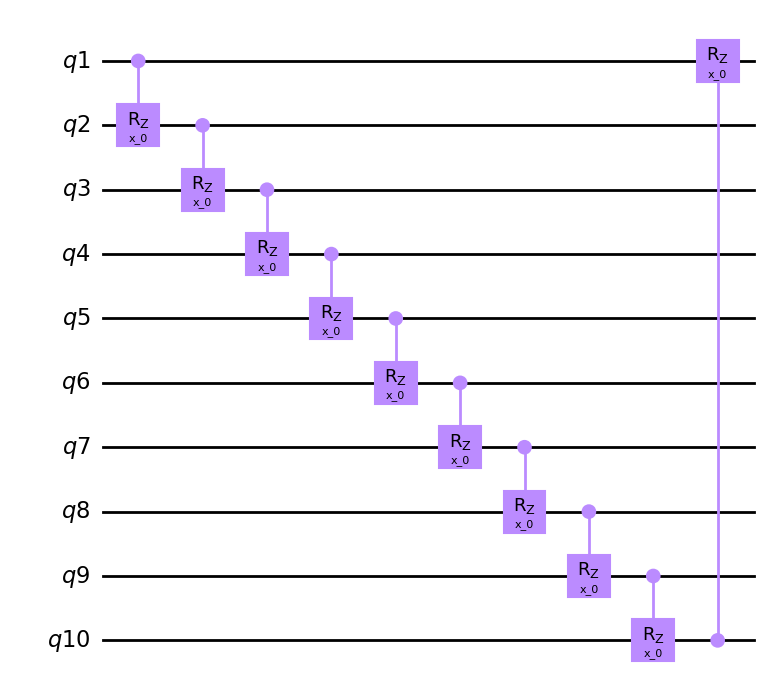

In [53]:
# Free primitive, can also recieve a list of qubit lables to make available.
free = Qfree(10) # or Qfree([2,6,4,10]) or Qfree([f"q{i}" for i in range(8)])
convolution_on_10_qubits = free + Qconv(1)

circuit, symbols = convert_graph_to_circuit_qiskit(convolution_on_10_qubits)
circuit.draw("mpl")

## Reverse binary tree

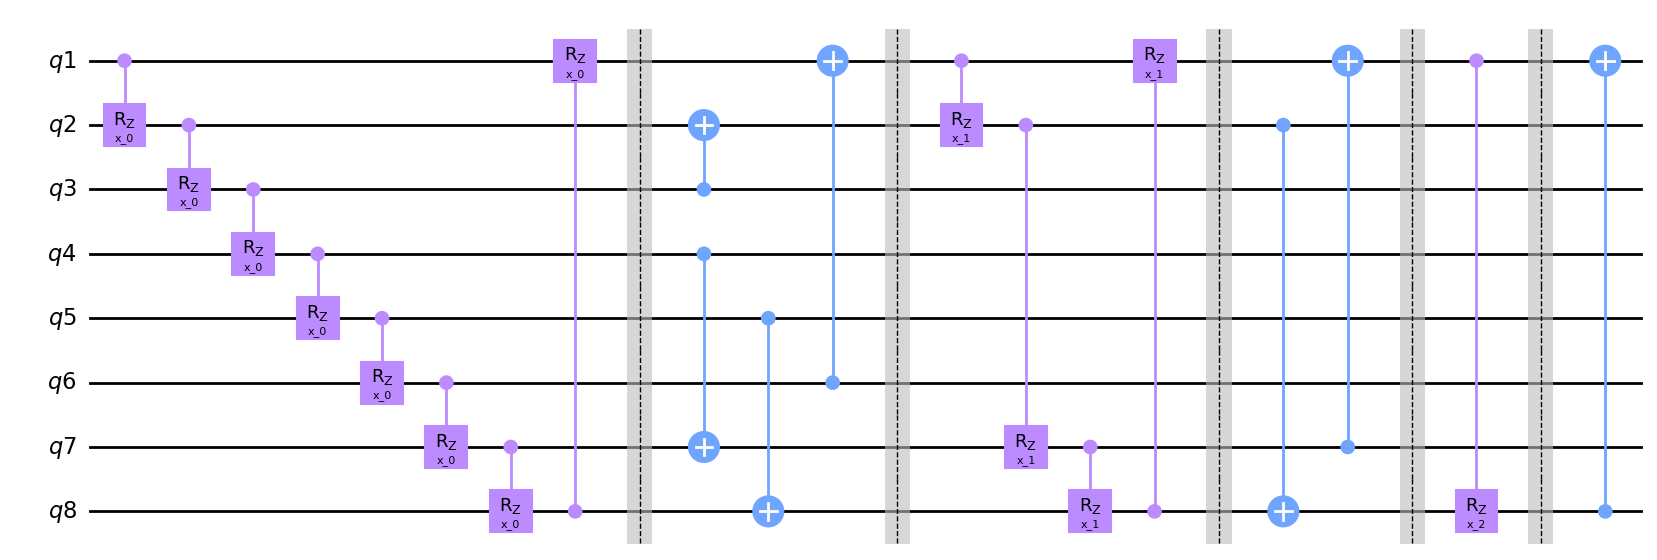

In [54]:
### Reverse binary tree

# Change these values
#---------
N = 8 # any power of two
s_c = 1 # 1,2,3, ...
f = "inside" # right, left, inside, outside, even, odd
s_p = 1 # 1,2,3, ...
#---------

# level 1
m1_1 = Qconv(stride=s_c)
m1_2 = Qpool(stride=s_p, filter=f)
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_qiskit(m3_1)
circuit.draw("mpl")

### More arbitrary examples to show what is possible

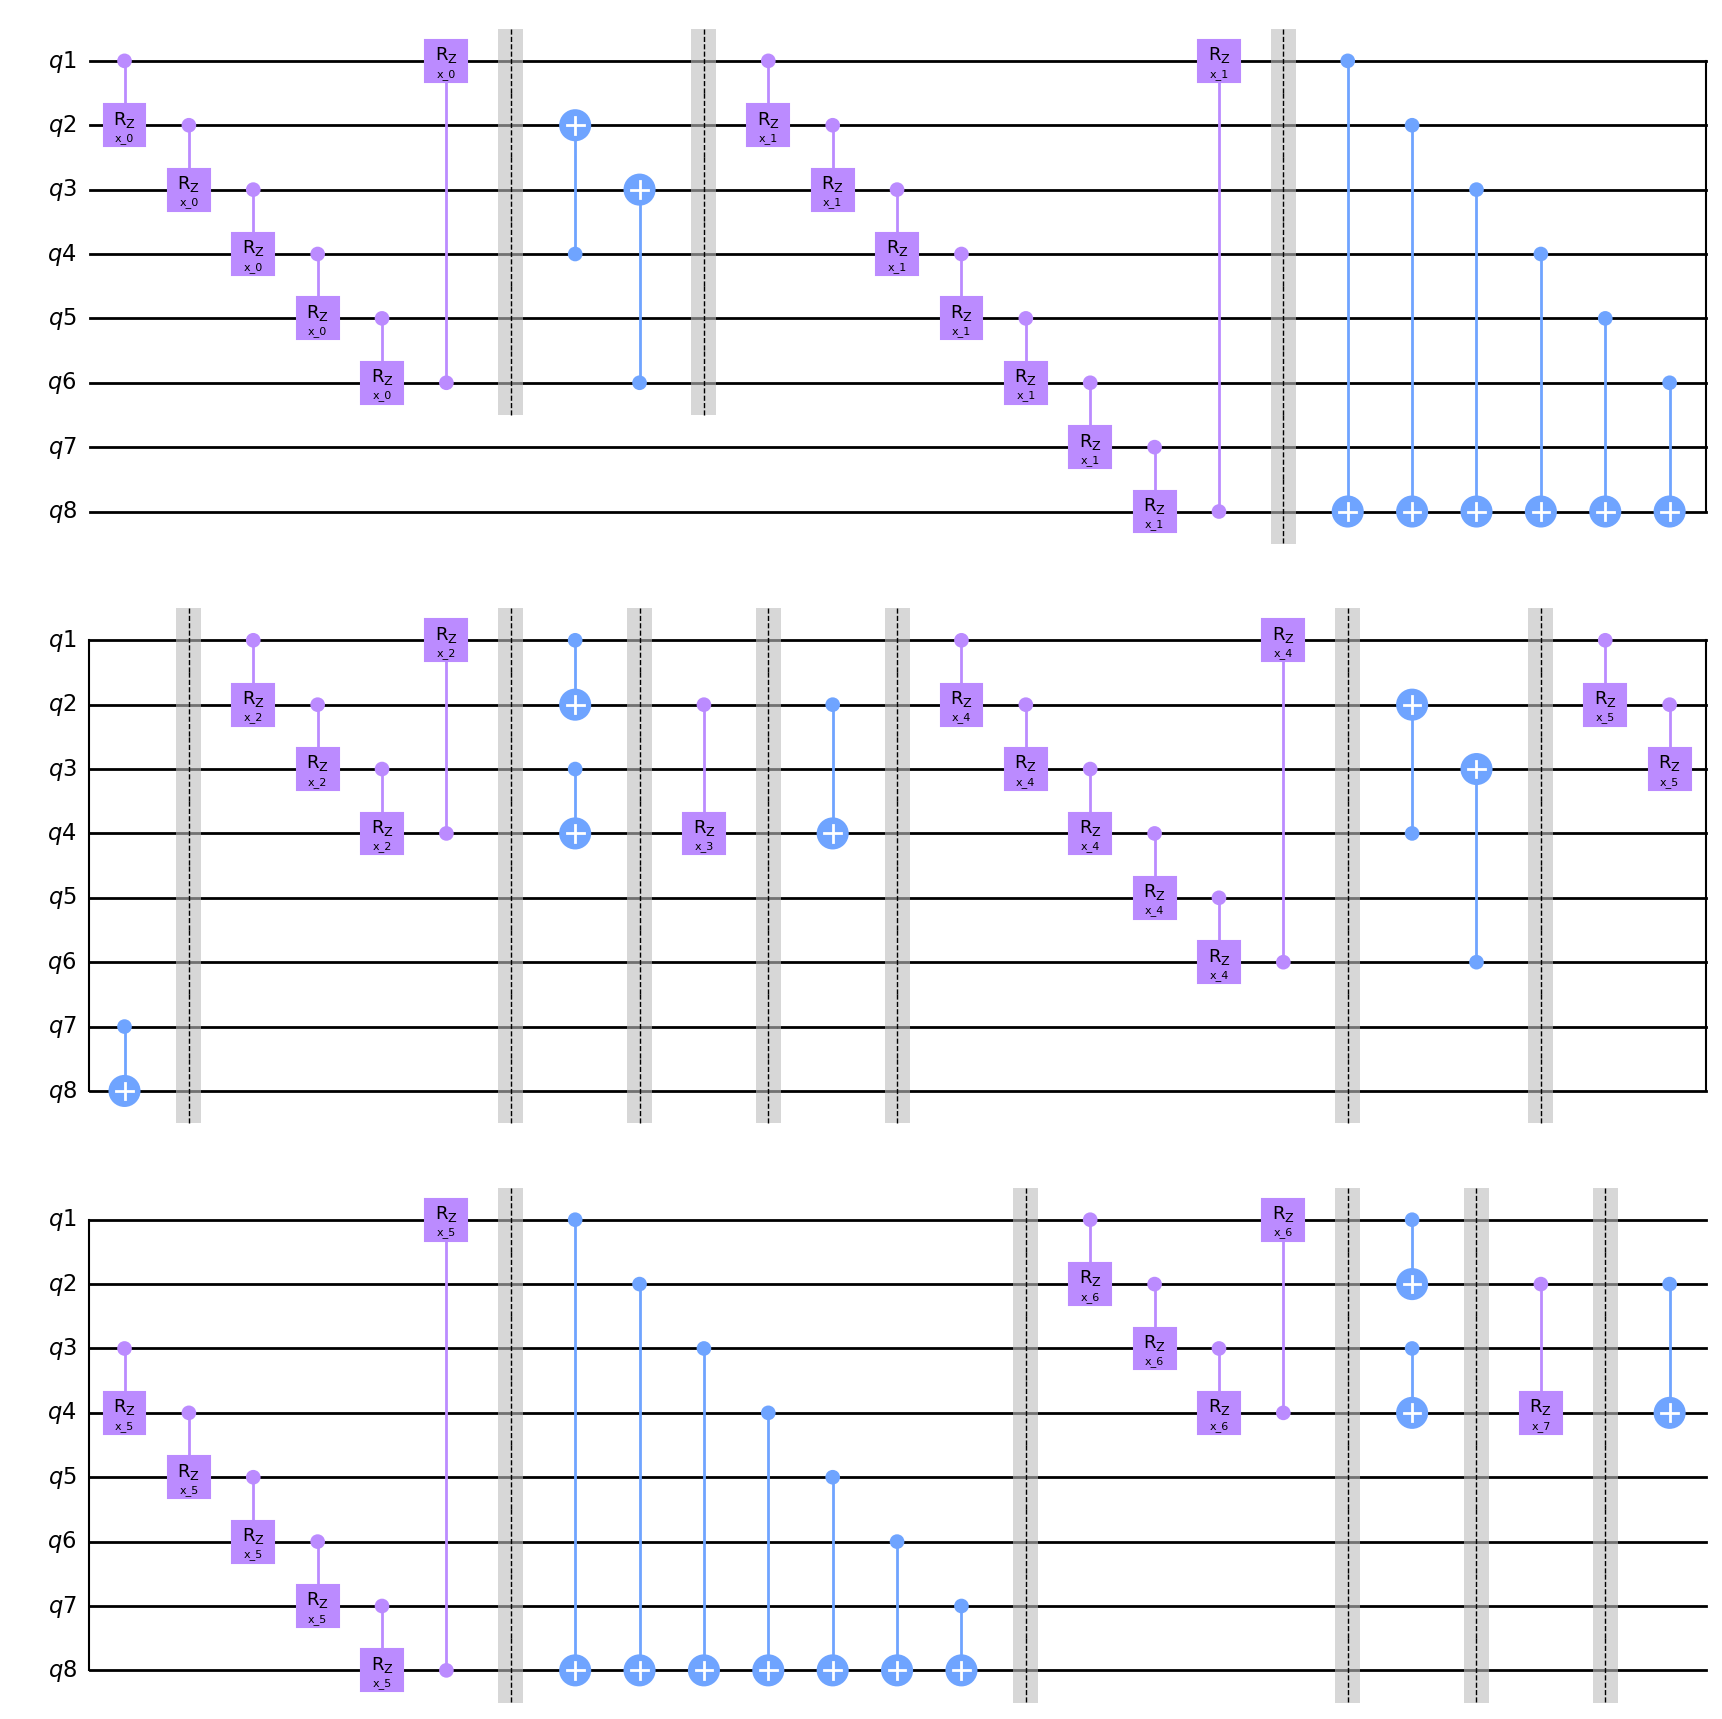

In [55]:
m1 = Qfree(6) + Qconv()
m2 = m1 + Qpool(1, "000101")
m3 = m2 + Qfree(8) + Qconv(1) + Qpool(2, "11111110")
m4 = m3 + Qfree(4) + (Qconv(1) + Qpool(0, "even")) * 2
m5 = m4 + m4
circuit, symbols = convert_graph_to_circuit_qiskit(m5)
circuit.draw("mpl")

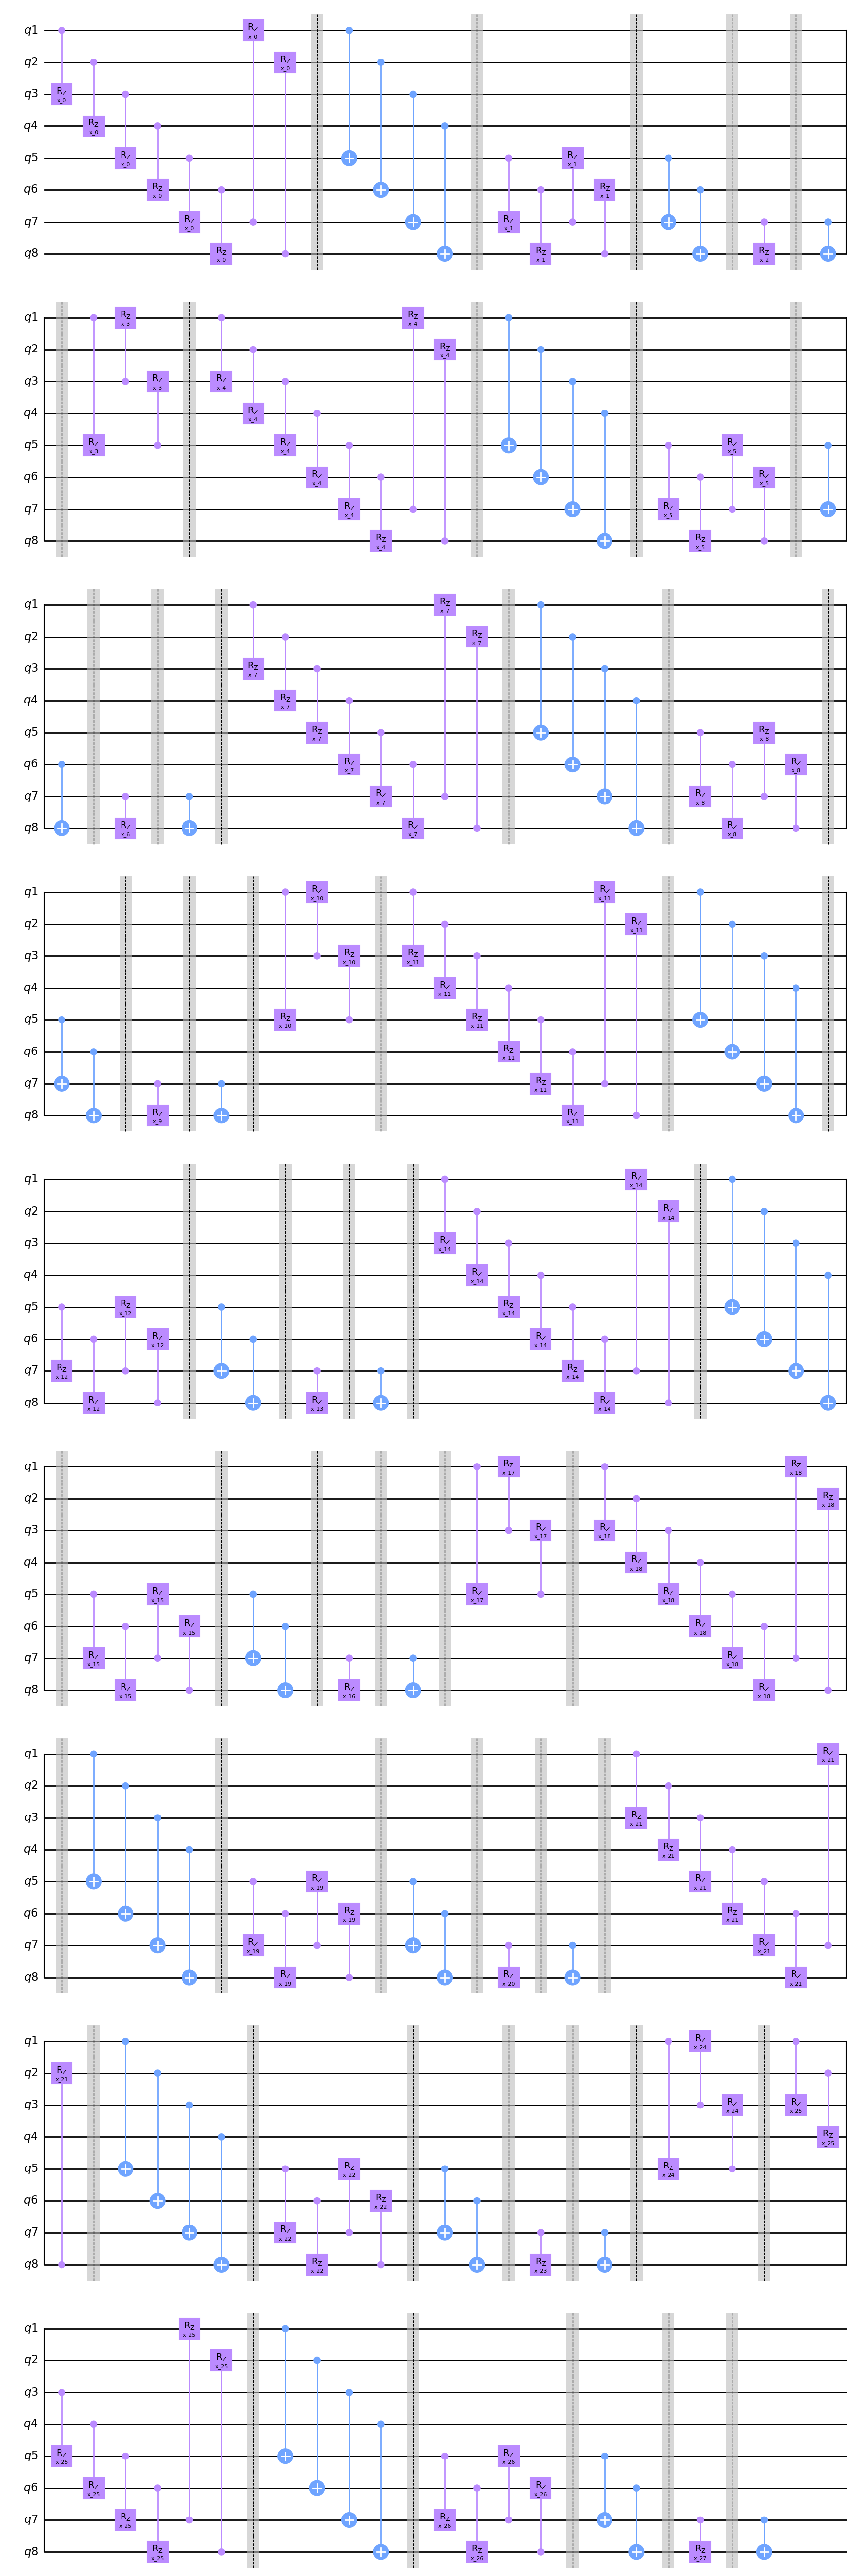

In [11]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_qiskit(
    (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4
)
circuit.draw("mpl")

## Multiscale Entanglement Renormalization Ansatz (MERA)

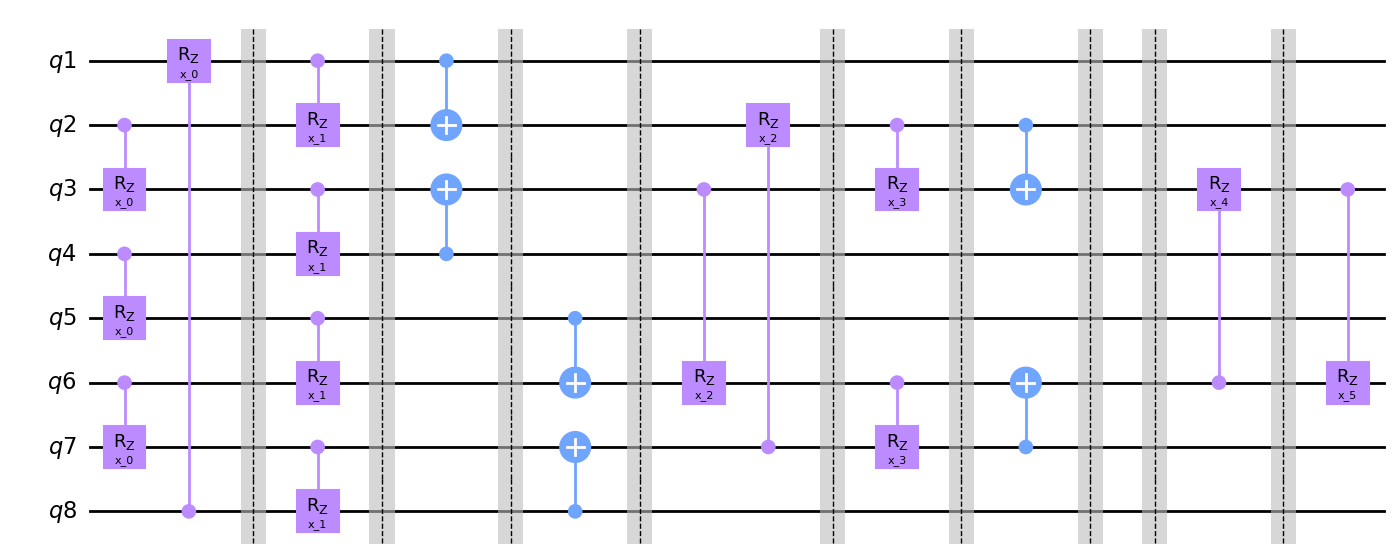

In [12]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

circuit, symbols = convert_graph_to_circuit_qiskit(m3_1)
circuit.draw("mpl")

## Random QCNNs

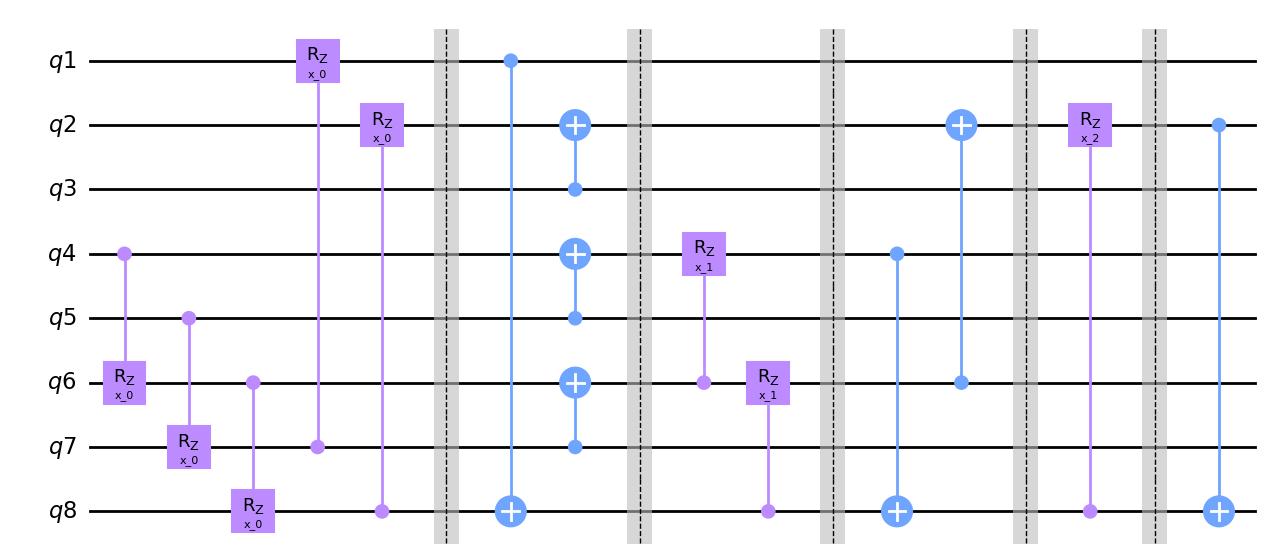

In [13]:
# More structure
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ]  # + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_qiskit(M)
circuit.draw("mpl")

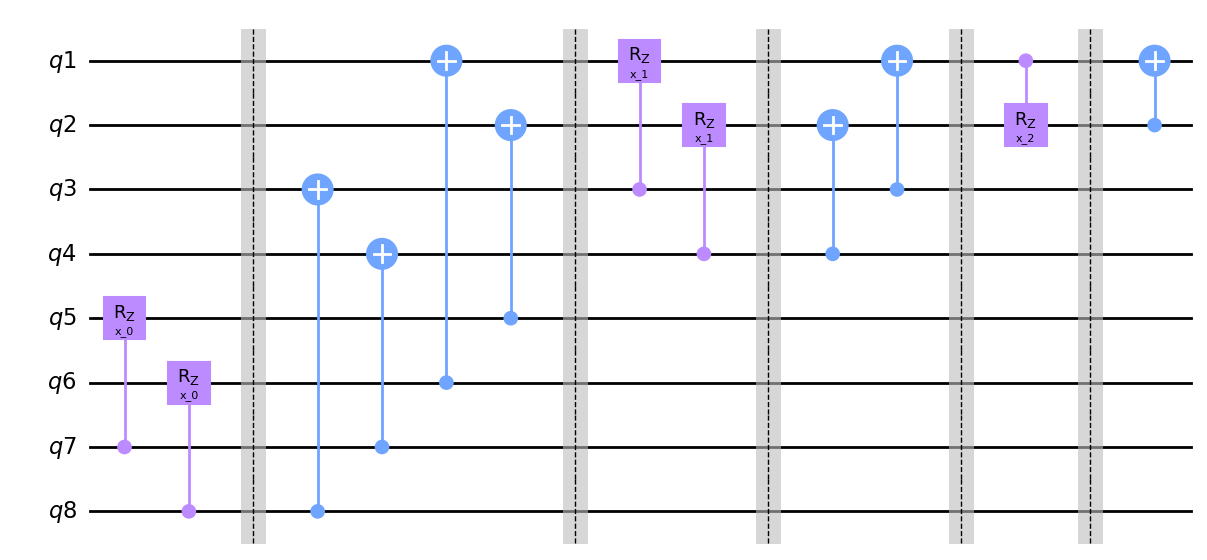

In [14]:
# loose
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ] + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_qiskit(M)
circuit.draw("mpl")

<a id='sec_customunitary'></a>
## Specifying custom unitaries

In [42]:
# Pooling circuit
def V(bits, symbols=None, circuit=None):
    q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0,q1)    
    # gate operations:
    circuit.crz(symbols[0],q0,q1)
    return circuit

# Convolution circuit
def U(bits, symbols=None, circuit=None):
    q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0,q1)    
    # gate operations:
    circuit.cnot(q0, q1)
    circuit.ry(symbols[0], q0)
    circuit.ry(symbols[1], q1)
    circuit.cnot(q0, q1)
    circuit.ry(symbols[2], q0)
    circuit.ry(symbols[3], q1)  
    return circuit


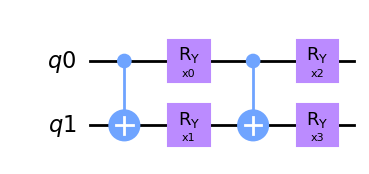

In [39]:
convolution_ansatz = U([0,1],[Parameter(f"x{i}") for i in range(4)])
convolution_ansatz.draw("mpl")

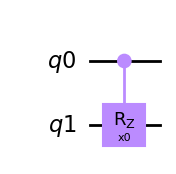

In [44]:
pooling_ansatz = V([0,1],[Parameter("x0")])
pooling_ansatz.draw("mpl")

In [45]:
M = (
    Qfree(8)
    + (
        Qconv(1, convolution_mapping=(U, 6))
        + Qpool(filter="left", pooling_mapping=(V, 1))
    )
    * 3
)
circuit, symbols = convert_graph_to_circuit_qiskit(M)

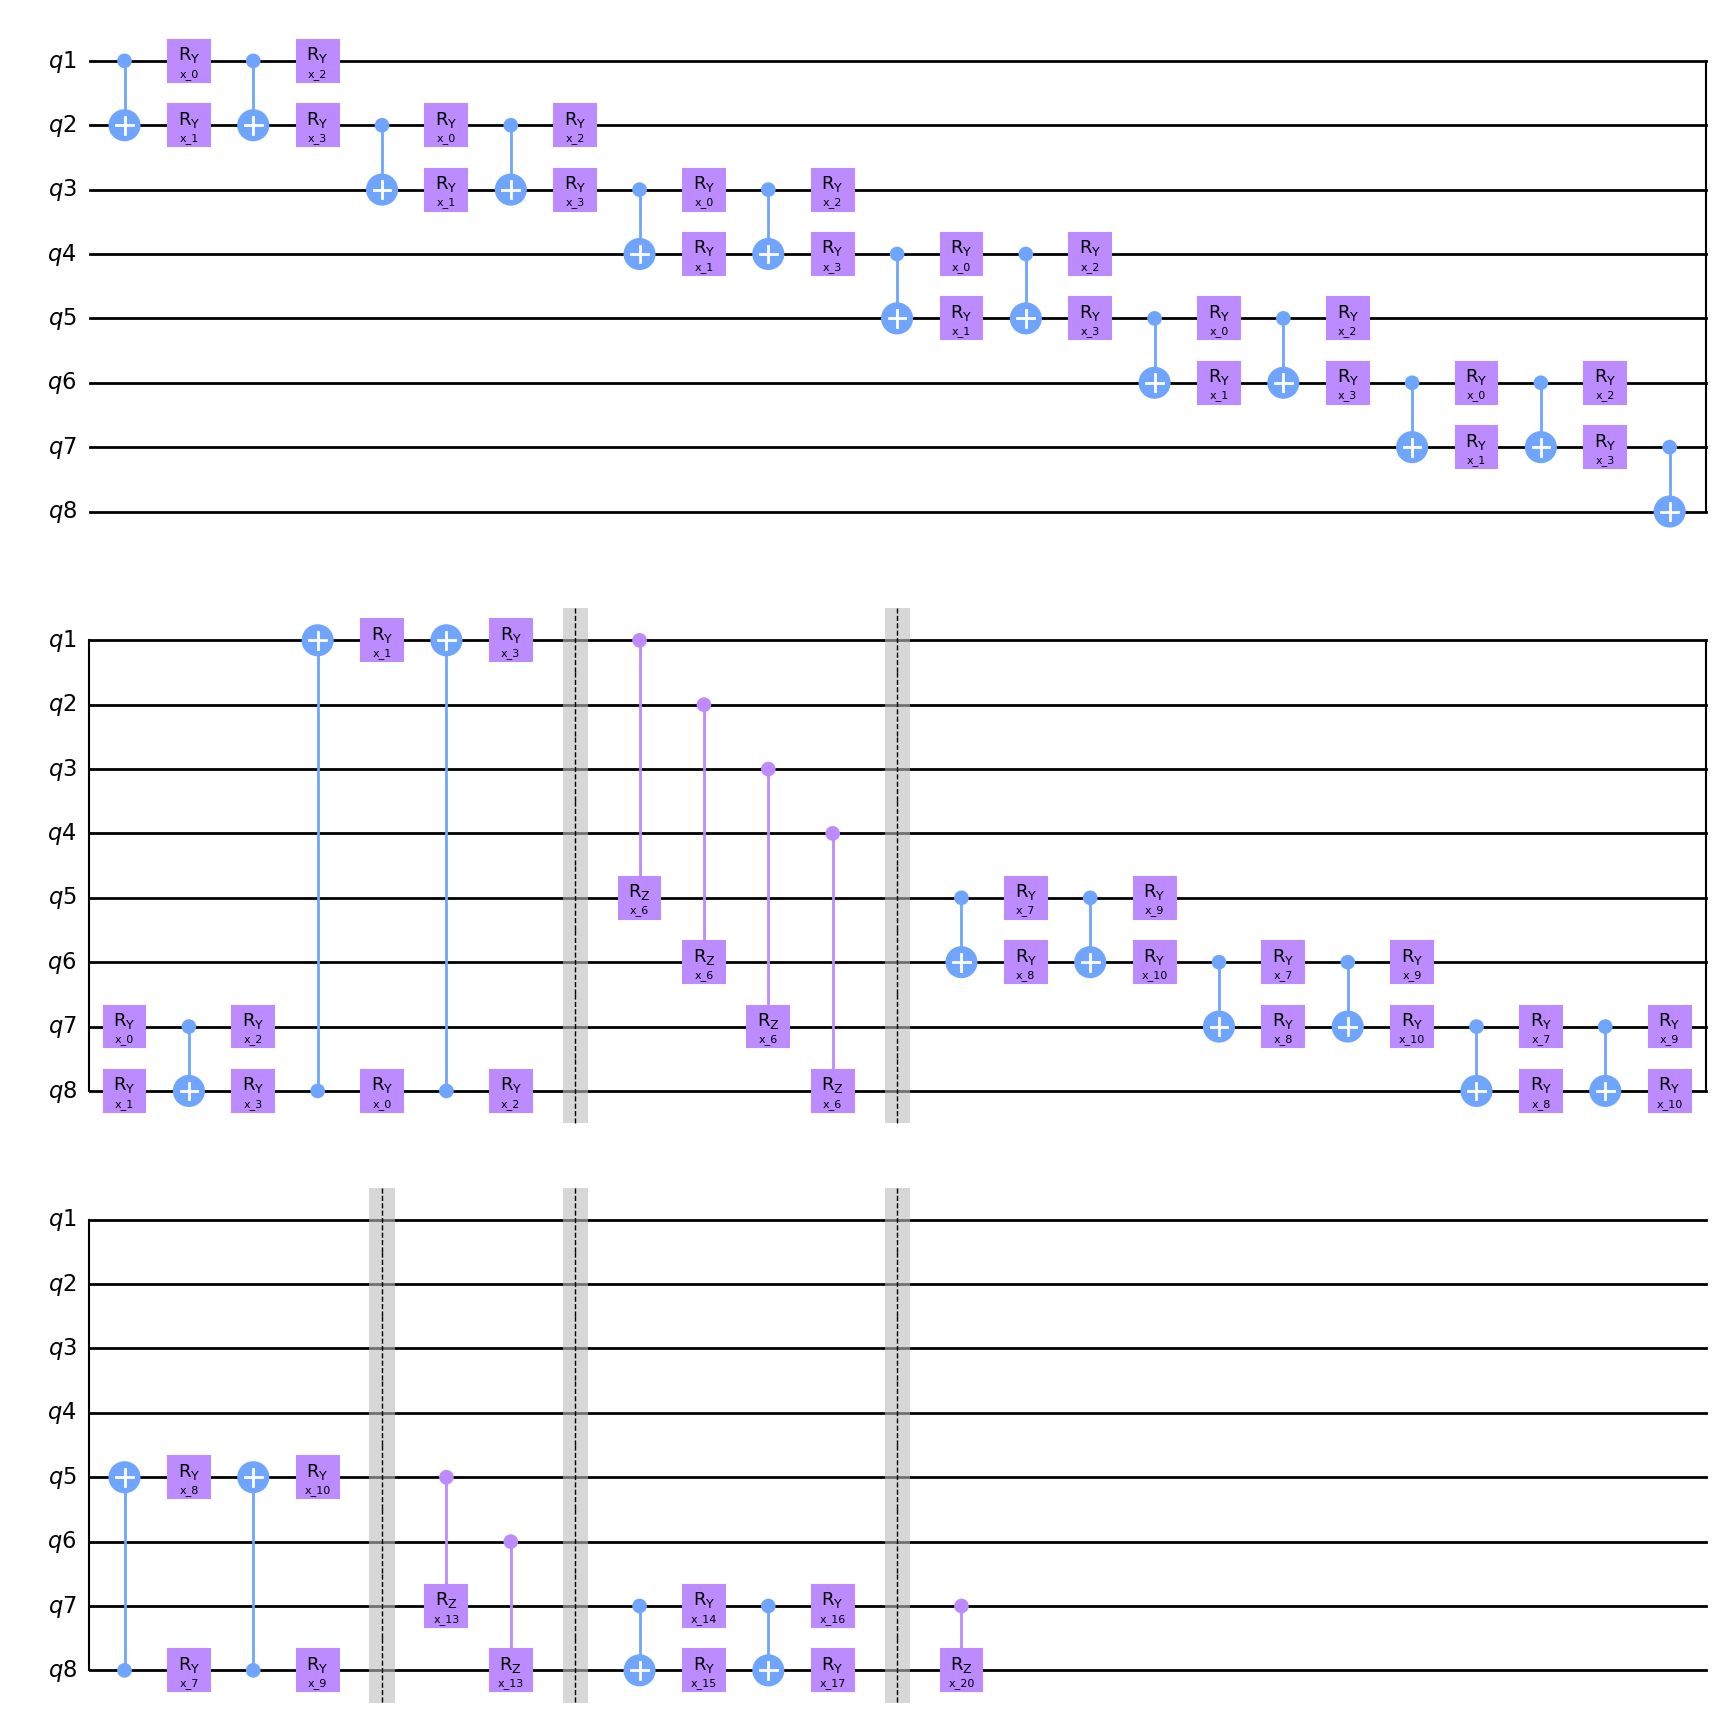

In [46]:
circuit.draw("mpl")

### Cycle through unitary ansatzes

In [47]:
# Pooling circuit
def V_1(bits, symbols=None, circuit=None):  # 1
    q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0,q1)    
    circuit.crx(symbols[0],q0,q1)
    return circuit


def V_2(bits, symbols=None, circuit=None):  # 0
    q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0,q1)
    circuit.cnot(q0,q1)
    return circuit


# Convolution circuit
def U_1(bits, symbols=None, circuit=None):  # 1
    q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0,q1)
    circuit.crz(symbols[0],q0,q1)
    return circuit


def U_2(bits, symbols=None, circuit=None):  # 1
    q0, q1 = QuantumRegister(1, f"q{bits[0]}"), QuantumRegister(1, f"q{bits[1]}")
    if circuit is None:
        circuit = QuantumCircuit()
        circuit.add_register(q0,q1)
    circuit.cry(symbols[0],q0,q1)
    return circuit



function_mappings = {
    "convolution": [(U_1, 1), (U_2, 1)],
    "pooling": [(V_1, 1), (V_2, 0)],
}

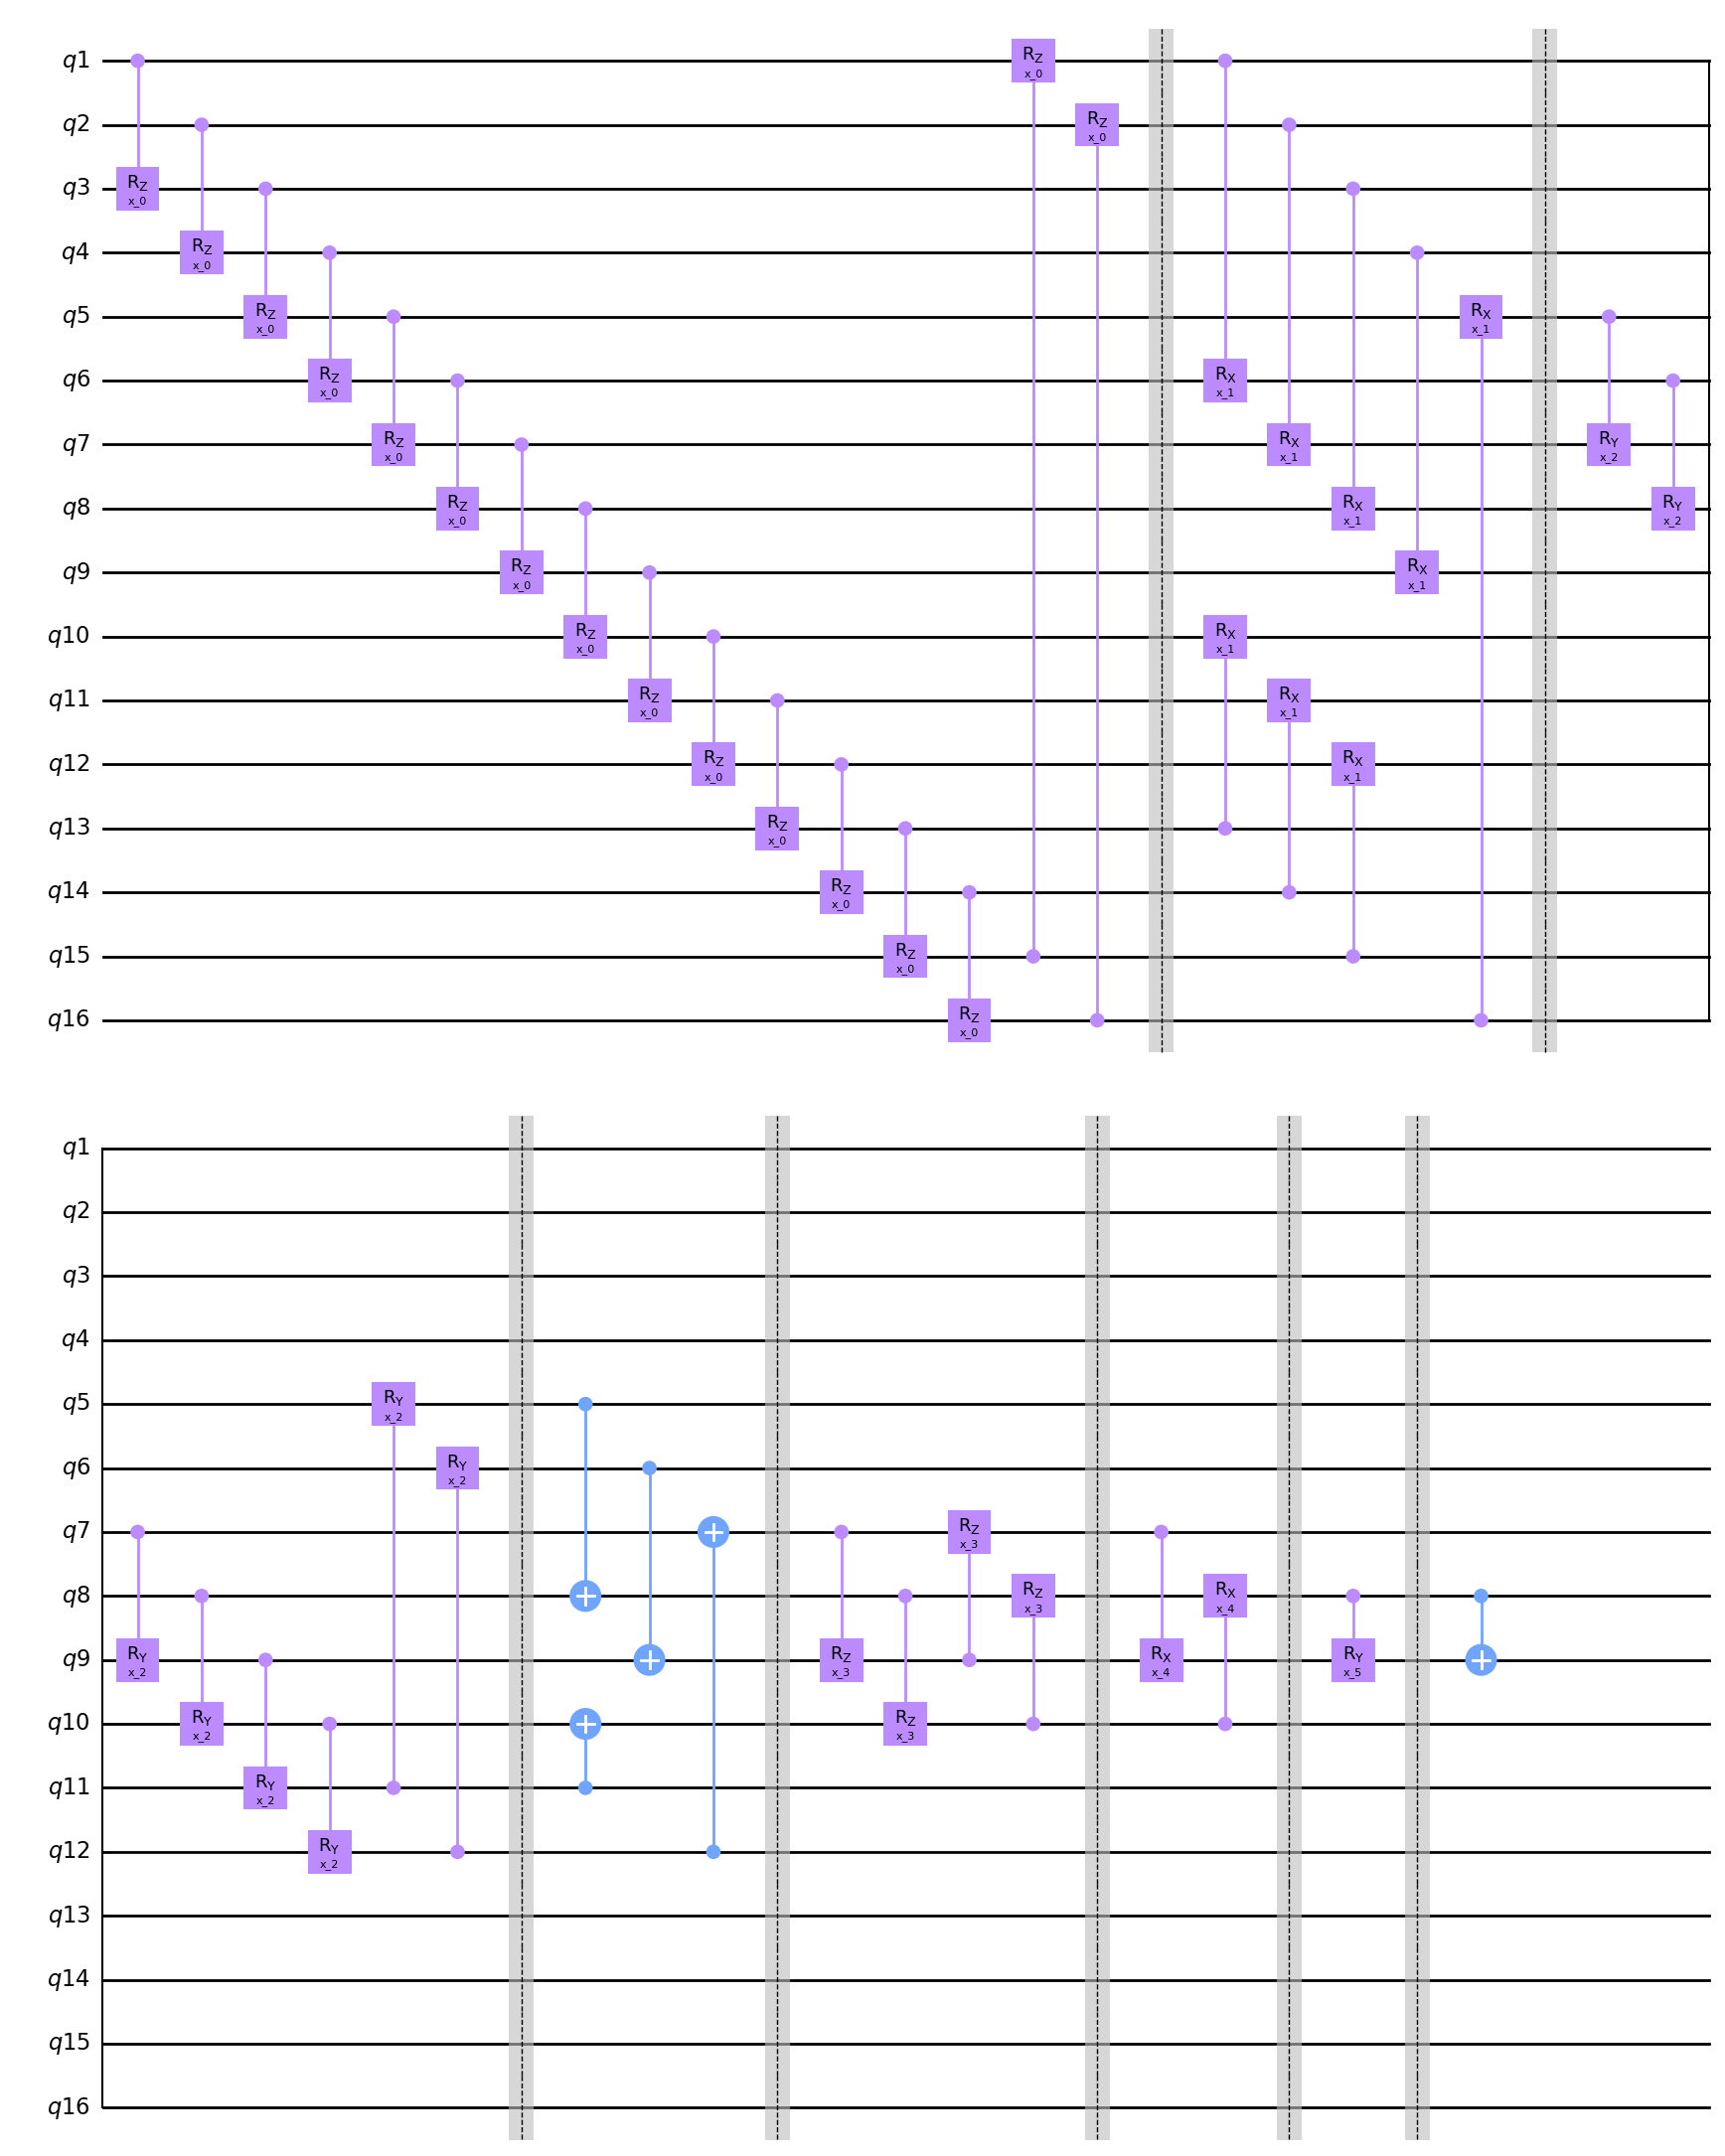

In [48]:
qcnn = Qcnn(16, function_mappings=function_mappings)

qcnn = qcnn + (Qconv(2) + Qpool(1, "outside")) * 4
circuit, symbols = convert_graph_to_circuit_qiskit(qcnn)
circuit.draw("mpl")

### Plot the graph view

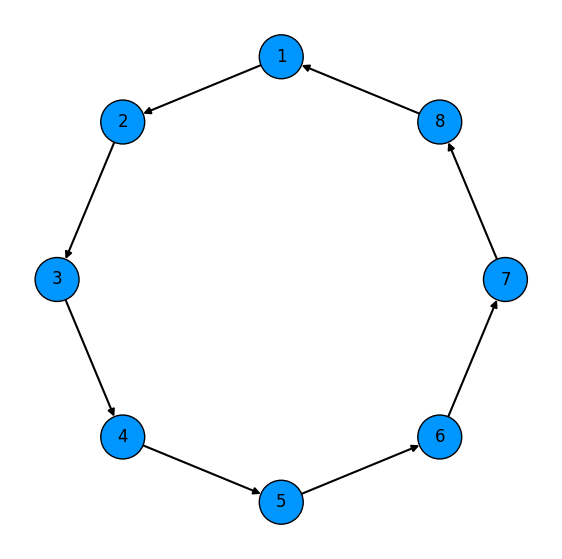

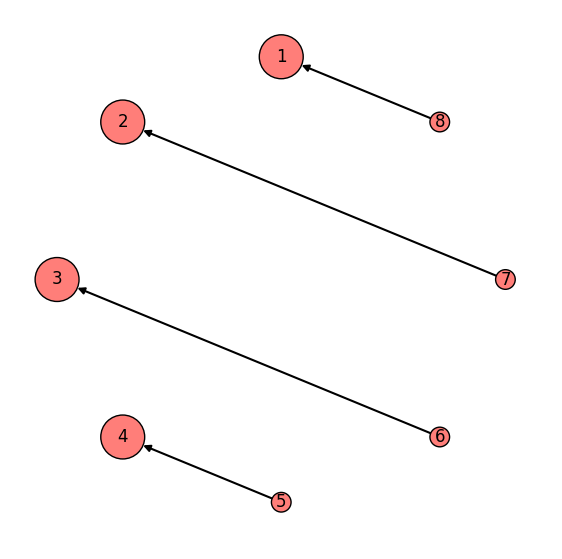

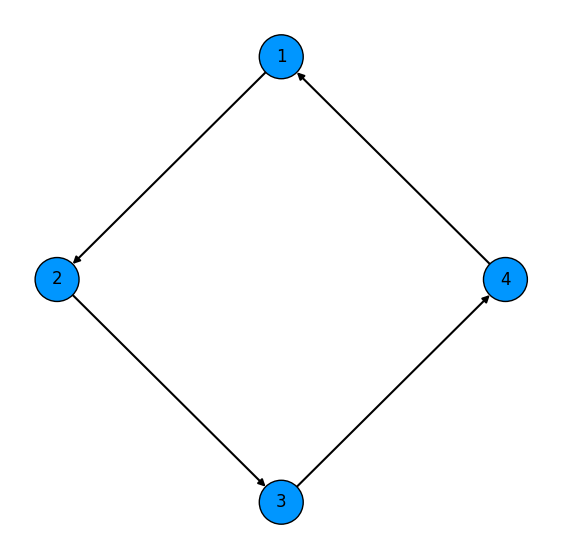

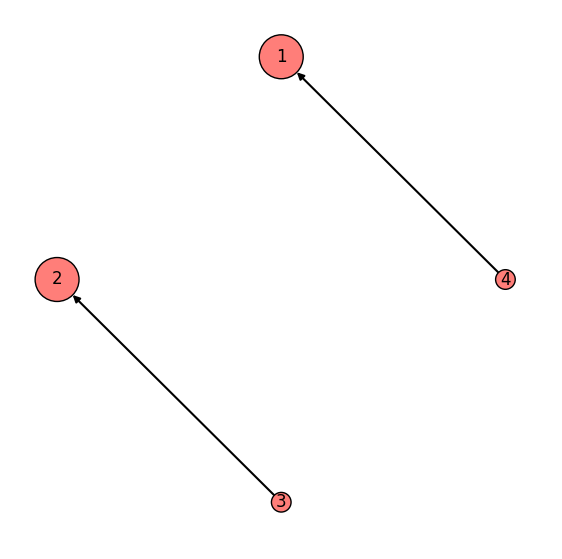

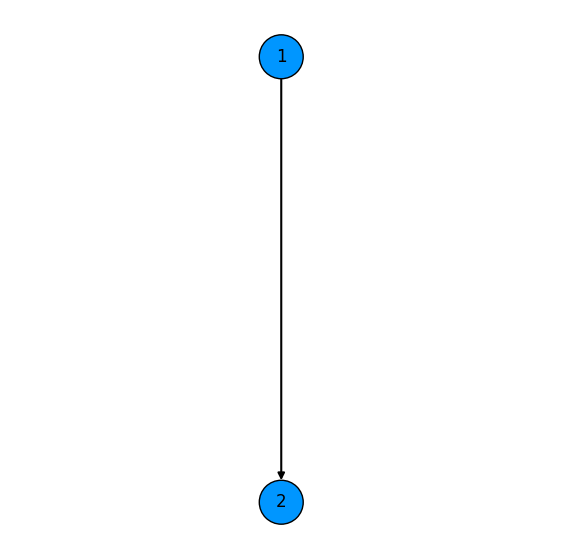

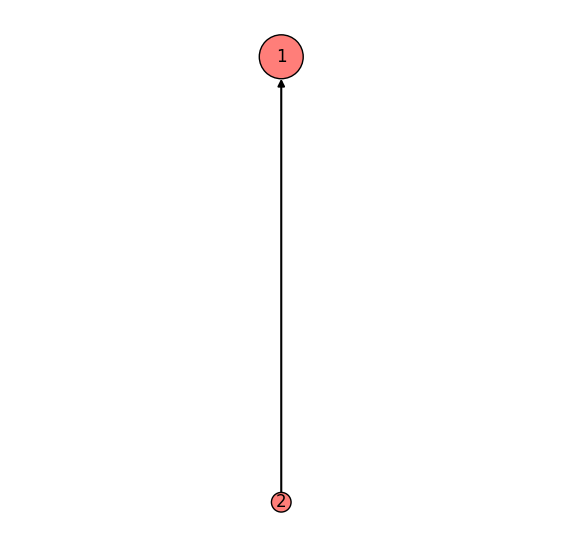

In [22]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3
for graph in m:
    a = plot_graph(graph)